In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rotations import angle_normalize, rpy_jacobian_axis_angle, skew_symmetric, Quaternion
from scipy.linalg import block_diag
# Load Data

file = open('data/data.pkl', 'rb')
data = pickle.load(file)


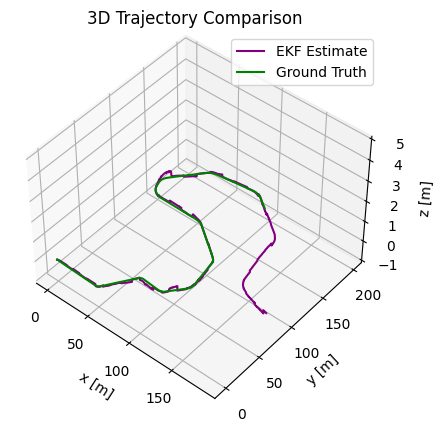

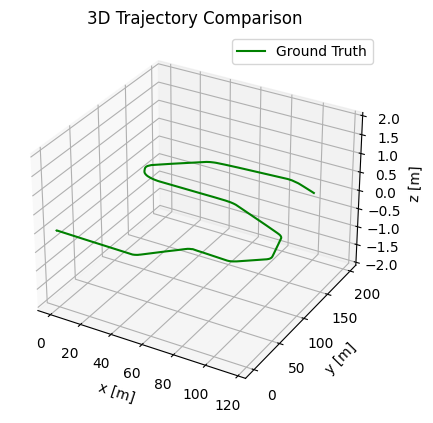

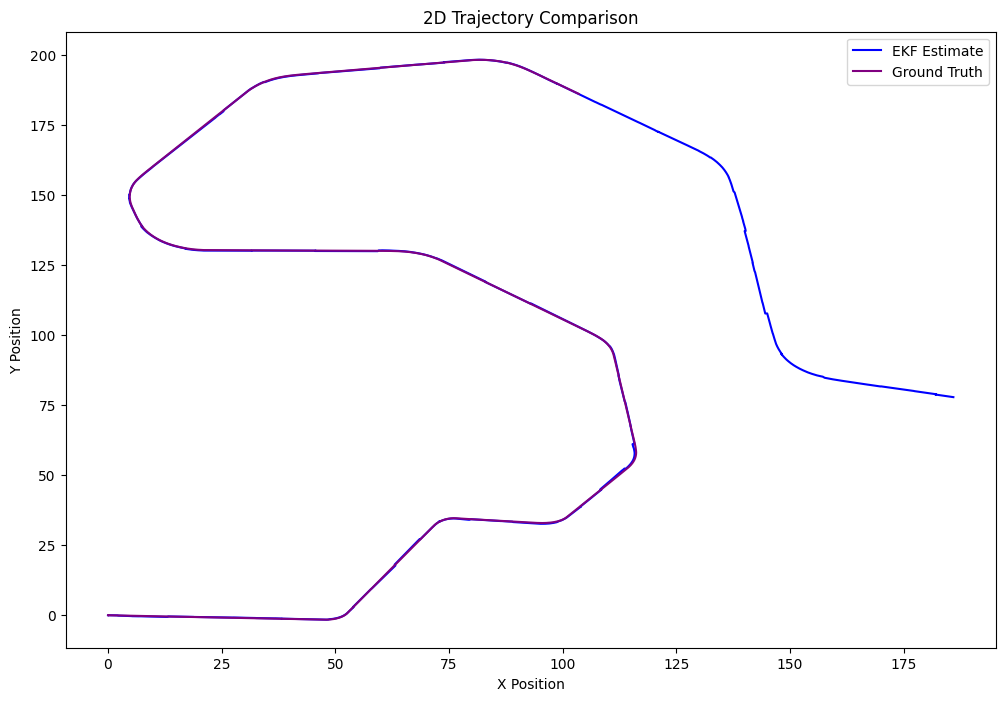

In [3]:
# Ground Truth

#     gt: Data object containing ground truth with the following fields:
#     a: Acceleration of the vehicle, in the inertial frame
#     v: Velocity of the vehicle, in the inertial frame
#     p: Position of the vehicle, in the inertial frame
#     alpha: Rotational acceleration of the vehicle, in the inertial frame
#     w: Rotational velocity of the vehicle, in the inertial frame
#     r: Rotational position of the vehicle, in Euler (XYZ) angles in the inertial frame
#     t: Timestamp in ms.

gt = data['gt']

# IMU Data

#     imu_f: StampedData object with the imu specific force (acceleration) data (given in vehicle frame).
#     data: The actual data
#     t: Timestamps in ms.
imu_f = data['imu_f']

#     imu_w: StampedData object with the imu rotational velocity (given in the vehicle frame).
#     data: The actual data
#     t: Timestamps in ms.
imu_w = data['imu_w']

# GNSS Data

#     gnss: StampedData object with the GNSS data.
#     data: The actual data
#     t: Timestamps in ms.
gnss = data['gnss']

# Lidar Data

#     lidar: StampedData object with the LIDAR data (positions only).
#     data: The actual data
#     t: Timestamps in ms.
lidar = data['lidar']

# Lidar calibration data

C_li = np.array([
    [0.99376, -0.09722, 0.05466],
    [0.09971, 0.99401, -0.04475],
    [-0.04998, 0.04992, 0.9975]
])

t_i_li = np.array([0.5, 0.1, 0.5])

# Transform from the LIDAR frame to the vehicle (IMU) frame.
lidar.data = (C_li @ lidar.data.T).T + t_i_li

# Parameters

# variances (HINT: you may use different values for each axis)

var_imu_f = 0.05
var_imu_w = 0.03
var_gnss  = 0.01
var_lidar = 1.00

# gravity
g = np.array([0, 0, -9.81])

# motion model noise jacobian
l_jac = np.zeros([9, 6])
l_jac[3:, :] = np.eye(6)

# measurement model jacobian
h_jac = np.zeros([3, 9])
h_jac[:, :3] = np.eye(3)  

## EKF initialization

# position estimates
p_est = np.zeros([imu_f.data.shape[0], 3])
# velocity estimates
v_est = np.zeros([imu_f.data.shape[0], 3])  
# orientation estimates as quaternions
q_est = np.zeros([imu_f.data.shape[0], 4])
# state covariance matrices
p_cov = np.zeros([imu_f.data.shape[0], 9, 9])

# set initial values
p_est[0] = gt.p[0]
v_est[0] = gt.v[0]
q_est[0] = Quaternion(euler=gt.r[0]).to_numpy()
p_cov[0] = np.zeros(9)

gnss_i = 0
lidar_i = 0

p_check = p_est[0]
v_check = v_est[0]
q_check = q_est[0]
p_cov_check = p_cov[0]


def measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check):

    H_k = h_jac  # Measurement model Jacobian
    R_k = np.eye(3) * sensor_var  # Measurement noise covariance
    # Compute Kalman Gain
    S = H_k @ p_cov_check @ H_k.T + R_k
    K_k = p_cov_check @ H_k.T @ np.linalg.inv(S)

    # Apply the update to the full state
    x_error = K_k @ (y_k - p_check)
    
    # Extract updated components
    p_hat, v_hat= p_check+x_error[0:3], v_check+x_error[3:6]
    
    axis_angle =  x_error[6:9] 
    quat_from_ag = Quaternion(axis_angle=axis_angle)
    q_hat = quat_from_ag.quat_mult_left(q_check, out='Quaternion')
    
    I = np.eye(p_cov_check.shape[0])
    p_cov_hat = (I - K_k @ H_k) @ p_cov_check

 
    return p_hat, v_hat, q_hat, p_cov_hat

# Main EKF loop
for k in range(1, imu_f.data.shape[0]):
   
    delta_t = imu_f.t[k] - imu_f.t[k - 1]

    # Rotation matrix from navigation frame to sensor frame
    C_ns = Quaternion(*q_est[k - 1]).to_mat()

    # Predict motion model
    f_k_minus_1 = imu_f.data[k - 1]
    p_check = p_est[k - 1] + delta_t * v_est[k - 1] + ((delta_t ** 2)/2) * (np.dot(C_ns,f_k_minus_1) + g)
    v_check = v_est[k - 1] + delta_t * (np.dot(C_ns,f_k_minus_1) + g)
    # Update quaternion using angular velocity
    axis_angle = imu_w.data[k - 1] * delta_t
    quaternion_1 = Quaternion(axis_angle=axis_angle)
    q_check = quaternion_1.quat_mult_right(q_est[k - 1], out='Quaternion')

    # f Jacobian
    f_jac = np.eye(9)
    f_jac[0:3, 3:6] = delta_t * np.eye(3)  # Position update part
    # Jacobian for the quaternion part 
    f_jac[3:6, 6:9] = -skew_symmetric(np.dot(C_ns,f_k_minus_1))*delta_t
    
    # Process noise covariance matrix
    Q_k_minus_1 = block_diag(delta_t**2 * var_imu_f * np.eye(3), delta_t**2 * var_imu_w * np.eye(3))

    p_cov_check= f_jac @ p_cov[k - 1] @ f_jac.T + l_jac @ Q_k_minus_1 @ l_jac.T


    if gnss_i < len(gnss.t) and imu_f.t[k] >= gnss.t[gnss_i]:
        p_check, v_check, q_check,p_cov_check = measurement_update(var_gnss, p_cov_check, gnss.data[gnss_i], p_check, v_check, q_check)
        gnss_i += 1
    
    if lidar_i < len(lidar.t) and imu_f.t[k] >= lidar.t[lidar_i]:
        p_check, v_check, q_check, p_cov_check = measurement_update(var_lidar, p_cov_check, lidar.data[lidar_i], p_check, v_check, q_check)
        lidar_i += 1

    # Update current state for the next iteration
    p_est[k],  v_est[k], q_est[k] = p_check,v_check, q_check.to_numpy()
    
    # # Update the covariance check variable for the next iteration
    p_cov[k]= p_cov_check 
 

# TODO: 
# Analysis of results (plot of states and along with their ground truth values)

#############Plotting 
    
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')

# Plot ground truth trajectory

# Plot EKF estimated trajectory
ax.plot(p_est[:, 0], p_est[:, 1], p_est[:, 2], label='EKF Estimate', color='purple')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2], label='Ground Truth', color='green')

# Set labels and title
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('3D Trajectory Comparison')
# Set Z-axis limits
ax.set_zlim(-1, 5)
ax.view_init(elev=45, azim=-50)

# Show legend
ax.legend()

# Show plot
plt.show()

gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')

# Plot ground truth trajectory
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2], label='Ground Truth', color='green')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('3D Trajectory Comparison')
ax.set_zlim(-2, 2)
ax.legend()
plt.show()

plt.figure(figsize=(12, 8))

plt.plot(p_est[:, 0], p_est[:, 1], label='EKF Estimate', color='blue')

plt.plot(gt.p[:, 0], gt.p[:, 1], label='Ground Truth', color='purple')


plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('2D Trajectory Comparison')
plt.legend()
plt.show()

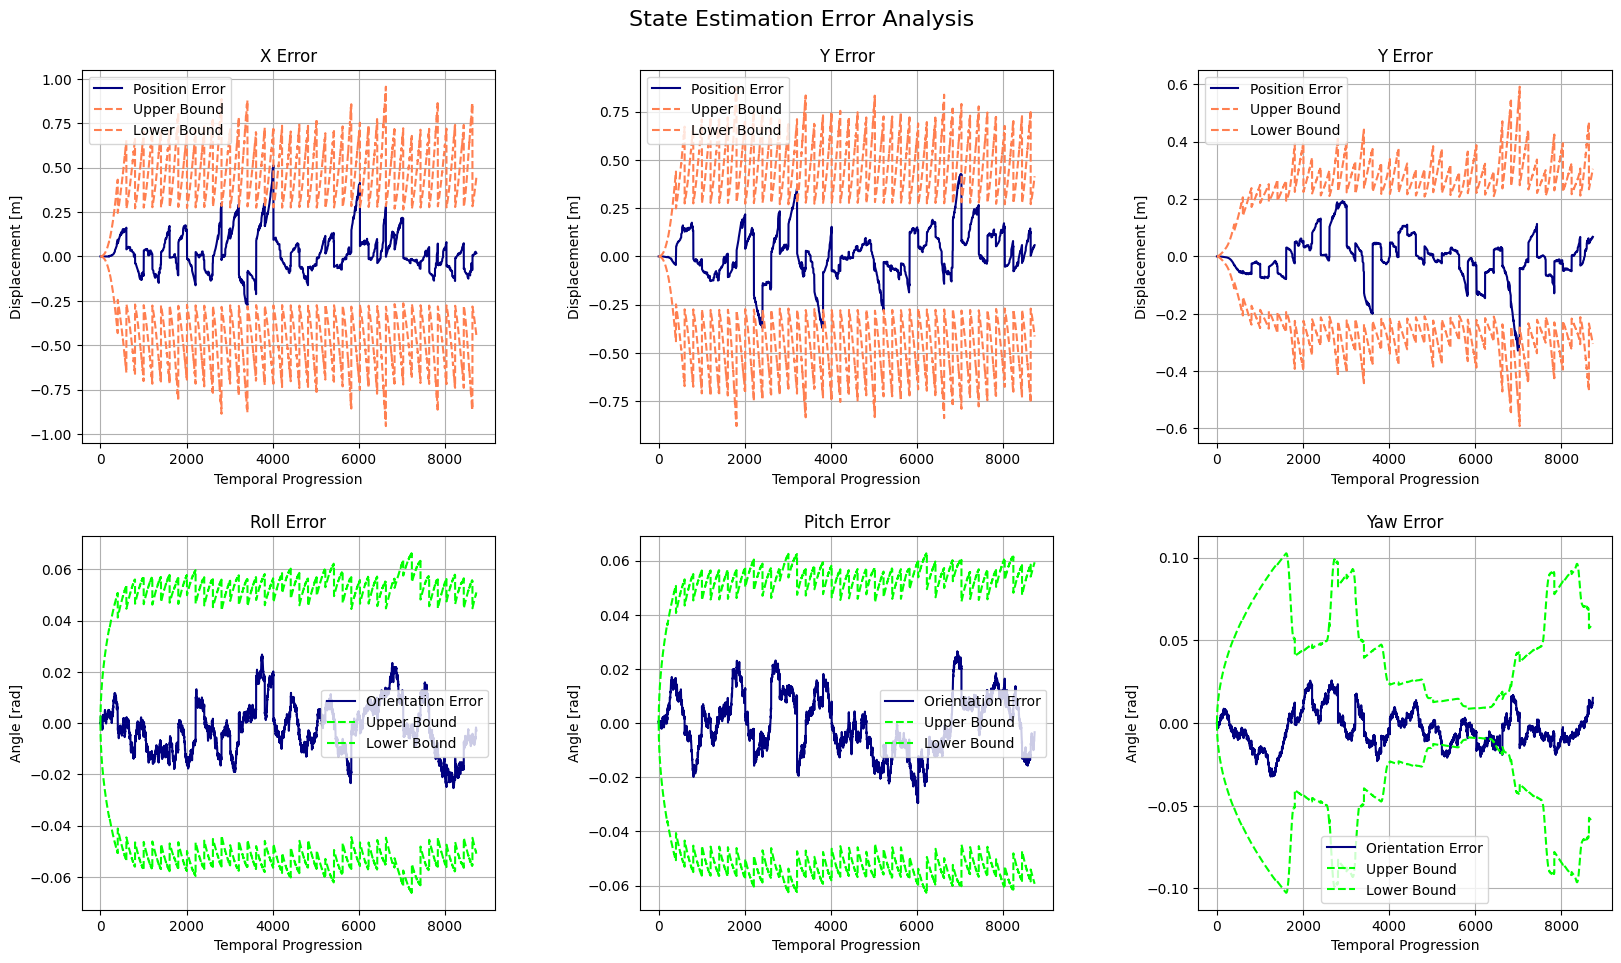

In [10]:
# Transform quaternion estimates to Euler angles
total_gt_samples = gt.p.shape[0]
estimated_euler_angles = np.array([Quaternion(*q_estimation).to_euler() for q_estimation in q_est])
estimated_euler_covariance = np.array([
    np.sqrt(np.diagonal(
        rpy_jacobian_axis_angle(Quaternion(*q_estimation).to_axis_angle()) @ 
        p_cov[i, 6:, 6:] @ 
        rpy_jacobian_axis_angle(Quaternion(*q_estimation).to_axis_angle()).T
    )) for i, q_estimation in enumerate(q_est)
])

# Calculate uncertainty from the covariance matrix
state_covariance_uncertainty = np.sqrt(np.diagonal(p_cov[:, :6, :6], axis1=1, axis2=2))

# Define plot aesthetics
plot_titles = ['X Error', 'Y Error', 'Y Error', 'Roll Error', 'Pitch Error', 'Yaw Error']
plot_colors = ['navy', 'coral', 'lime']
dash_styles = ['solid', 'dashed', 'dashdot']

# Set up the error plots
error_figure, axis_panels = plt.subplots(2, 3, figsize=(18, 10))
error_figure.suptitle('State Estimation Error Analysis', fontsize=16)

# Visualize the position error
for idx in range(3):
    axis_panels[0, idx].plot(gt.p[:, idx] - p_est[:total_gt_samples, idx], color=plot_colors[0], label='Position Error')
    axis_panels[0, idx].plot(3 * state_covariance_uncertainty[:total_gt_samples, idx], color=plot_colors[1], linestyle=dash_styles[1], label='Upper Bound')
    axis_panels[0, idx].plot(-3 * state_covariance_uncertainty[:total_gt_samples, idx], color=plot_colors[1], linestyle=dash_styles[1], label='Lower Bound')
    axis_panels[0, idx].set_title(plot_titles[idx])
    axis_panels[0, idx].set_xlabel('Temporal Progression')
    axis_panels[0, idx].set_ylabel('Displacement [m]')
    axis_panels[0, idx].legend(loc='best')
    axis_panels[0, idx].grid(visible=True)

# Visualize the orientation error
for idx in range(3):
    axis_panels[1, idx].plot(
        angle_normalize(gt.r[:, idx] - estimated_euler_angles[:total_gt_samples, idx]), 
        color=plot_colors[0], label='Orientation Error'
    )
    axis_panels[1, idx].plot(
        3 * estimated_euler_covariance[:total_gt_samples, idx], 
        color=plot_colors[2], linestyle=dash_styles[1], label='Upper Bound'
    )
    axis_panels[1, idx].plot(
        -3 * estimated_euler_covariance[:total_gt_samples, idx], 
        color=plot_colors[2], linestyle=dash_styles[1], label='Lower Bound'
    )
    axis_panels[1, idx].set_title(plot_titles[idx+3])
    axis_panels[1, idx].set_xlabel('Temporal Progression')
    axis_panels[1, idx].set_ylabel('Angle [rad]')
    axis_panels[1, idx].legend(loc='best')
    axis_panels[1, idx].grid(visible=True)

# Fine-tune the layout of the plot
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

# Render the plot
plt.show()
